In [4]:
import sys,os
sys.path.append(os.pardir)

import numpy as np
from common.layers import MatMul

#샘플 맥락 데이터
C0=np.array([[1,0,0,0,0,0,0]])
C1=np.array([[0,0,1,0,0,0,0]])

#가중치 초기화
W_in=np.random.randn(7,3)
W_out=np.random.randn(3,7)

#계층 생성
in_layer0=MatMul(W_in)
in_layer1=MatMul(W_in)
out_layer=MatMul(W_out)

#순전파
h0=in_layer0.forward(C0)
h1=in_layer1.forward(C1)
h=0.5*(h0+h1)
score=out_layer.forward(h)

print(score)

[[-1.32422851  1.00312594 -0.3760852  -1.80438931  0.55893307  1.12588765
  -0.96922528]]


word2vec을 이용한 학습 준비

In [13]:
import sys,os
sys.path.append(os.pardir)
from common.util import preprocess

text='You say goodbye and I say hello.'
corpus, word_to_id, id_to_word=preprocess(text)
print(corpus)

print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [14]:
def create_contexts_target(corpus, window_size=1):
    # target은 corpus에서 윈도우 크기를 기준으로 예측할 중심 단어입니다.
    target = corpus[window_size: -window_size]  # 이 부분은 오류가 있을 수 있음, 아래에서 수정됨

    contexts = []  # 문맥 단어들을 저장할 리스트

    # 문맥 단어를 만들기 위한 루프
    for idx in range(window_size, len(corpus) - window_size):
        cs = []  # 현재 단어에 대한 문맥 단어들을 저장할 리스트
        for t in range(-window_size, window_size + 1):
            if t == 0:  # 중심 단어는 제외하고 문맥 단어들만 사용
                continue
            cs.append(corpus[idx + t])  # 윈도우 범위 내의 단어를 문맥 리스트에 추가
        contexts.append(cs)  # 문맥 리스트를 contexts에 추가

    # 문맥과 타겟을 numpy 배열로 변환하여 반환
    return np.array(contexts), np.array(target)

In [15]:
contexts, target=create_contexts_target(corpus, window_size=1)

print(contexts)

print()

print(target)           

#현재 contexts와 target은 단어 ID로 구성되어 있다. 이어서 이를 원핫 벡터로 표현해보자.

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]

[1 2 3 4 1 5]


In [16]:
# convert_one_hot() 함수를 이용해서 (6,2)의 단어 ID를 원핫 표현으로 (6,2,7)로 만들어준다.


def convert_one_hot(corpus, vocab_size):
    '''원핫 표현으로 변환
    :param corpus: 단어 ID 목록(1차원 또는 2차원 넘파이 배열)
    :param vocab_size: 어휘 수
    :return: 원핫 표현(2차원 또는 3차원 넘파이 배열)
    '''
    N = corpus.shape[0]
    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1
            
    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1
                
    return one_hot

import sys, os
sys.path.append(os.pardir)
from common.util import preprocess, create_contexts_target, convert_one_hot

text='You say goodbye and I say hello.'

corpus, word_to_id, id_to_word=preprocess(text)

contexts, target=create_contexts_target(corpus, window_size=1)

vocab_size=len(word_to_id)
target=convert_one_hot(target,vocab_size)
contexts=convert_one_hot(contexts,vocab_size)

학습 데이터 준비를 마쳤으니 본론인 CBOW 모델 구현을 해보자.

In [ ]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from common.layers import MatMul,SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V,H= vocab_size, hidden_size

        #가중치 초기화
        W_in=0.01*np.random.randn(V,H).astype('f')      # 32비트 부동소수점 수로 초기화된다.          
        W_out=0.01*np.random.randn(H,V).astype('f')

        #계층 생성
        self.in_layer0=MatMul(W_in)
        self.in_layer1=MatMul(W_in)
        self.out_layer=MatMul(W_out)
        self.loss_layer=SoftmaxWithLoss()

        #모든 가중치와 기울기를 리스트에 모은다.
        layers=[self.in_layer0,self.in_layer1,self.out_layer,self.loss_layer]
        self.params, self.grad=[],[]
        for layer in layers:
            self.params+=layer.params
            self.grads+=layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs=W_in

    def forward(self,contexts,target):
        h0=self.in_layer0.forward(contexts[:, 0])
        h1=self.in_layer1.forward(contexts[:,1])
        h=(h0+h1)*0.5
        score=self.out_layer.forward(h)
        loss=self.loss_layer.forward(score,target)

        return loss
    
    def backward(self,dout=1):
        ds=self.loss_layer.backward(dout)
        da=self.out_layer.backward(ds)
        da*=0.5
        self.in_layer1.backward(da)             #알아서 MatMul layer의 grad에 저장이 된다.
        self.in_layer0.backward(da)

        return None


| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

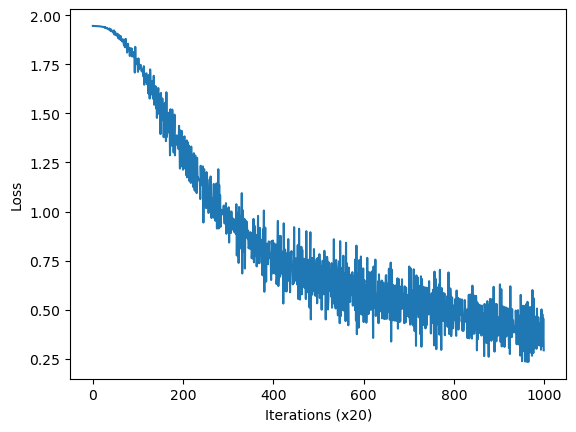

In [ ]:
# chap03/train.py
import sys
sys.path.append('..')
from common.trainer import Trainer
from common.optimizer import Adam
from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot


window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
# cbow 학습 데이터셋 생성
contexts, target = create_contexts_target(corpus, window_size)
# Input에 맞는 one-hot 표현 변환
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

# 모델 초기화
model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts,target,max_epoch, batch_size)
trainer.plot()

In [ ]:
# 입력층 MatMul 계층의 가중치는 인스턴스 변수 word_vecs에 저장되어 있으니, 학습이 끝난 후의 가중치 매개변수를 살펴보자.
word_vecs=model.word_vecs1
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

# 결과를 보고 알 수 있는 것은, 123p에서 언급했듯이, 가중치의 행이 단어의 분산표현의 정체다.(그림을 그려보면 알 수 있다.) 
# 그리고 현재는 단어를 밀집 벡터로 나타낸 것이다.

you [ 1.0257641 -1.7338622  1.0033846  0.9675281 -1.011387 ]
say [-0.29819125 -1.2635125  -1.4336978  -0.7416734   0.6859186 ]
goodbye [ 0.8566709   0.3306638   1.029813    1.1388626  -0.89258826]
and [ 1.4085153 -0.8440928 -1.33379   -1.4951497 -1.5163859]
i [ 0.8507163   0.30853614  1.0281018   1.1096641  -0.8702646 ]
hello [ 1.0223112  -1.7216083   0.99050206  0.97062784 -1.0023322 ]
. [-1.2377367 -1.2686956 -0.9575367  1.3864269  1.2282804]


In [ ]:
# simple_skip_gram.py

# chap03/simple_skip_gram.py
import sys,os
sys.path.append(os.pardir)
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss


class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        # 레이어 생성
        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        # 인스턴스 변수에 단어의 분산표현을 저장한다.
        self.word_vecs1 = W_in
        self.word_vecs2 = W_out.T
        
    def forward(self, contexts, target):
        h = self.in_layer.forward(target)                       # 입력이 target이고 출력이 contexts다.
        s = self.out_layer.forward(h)
        l1 = self.loss_layer1.forward(s, contexts[:, 0])
        l2 = self.loss_layer2.forward(s, contexts[:, 1])
        loss = l1 + l2
        return loss
    
    def backward(self, dout=1):
        dl1 = self.loss_layer1.backward(dout)
        dl2 = self.loss_layer2.backward(dout)
        ds = dl1 + dl2
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        return None